In [41]:
# Import packages
import pandas as pd
import numpy as np
#from w2v_utils import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re # regular expresson package
# Import NLP packages
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Import keras for NN implementation
from keras.models import Model
from keras.models import Sequential
from keras.layers import Embedding, Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Import sklearn packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

In [17]:
# Load the data
data = pd.read_csv('spam.csv', usecols = [0,1], encoding='latin-1')
data.columns = ['label', 'text']
print("The data has", data.shape[0], "row(s) and ", data.shape[1], "column(s)")
data.head()

The data has 5572 row(s) and  2 column(s)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
# Get a word count and unique word count of the text
data.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

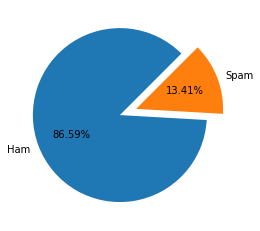

In [31]:
x = data.groupby('label').describe()
# Get the number of ham and spam
num_ham = x['text']['count'][0]
num_spam = x['text']['count'][1]
# plot a pie chart to show how many spams and hams
plt.pie([num_ham, num_spam],labels=["Ham", "Spam"],explode=(0,0.2),autopct='%1.2f%%',startangle=45)
plt.show()

In [34]:
data

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [35]:
# Encode ham and spam into binary number
le = LabelEncoder()
data.label = le.fit_transform(data.label)
data

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


We are going to try lemmatization and stopword removal. However, conventional processing techniques are not going to work well with a SMS corpus. The texts have a lot of shortened words and abbreviations. Ideally, we have to implement a customized normalization of text.

In [44]:
total_stopwords = set([word.replace("'",'') for word in stopwords.words('english')])
lemma = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower() # Convert to lowercase
    text = text.replace("'",'') # 
    text = re.sub('[^a-zA-Z]',' ',text)
    words = text.split()
    words = [lemma.lemmatize(word) for word in words if (word not in total_stopwords) and (len(word)>1)] # Remove stop words
    text = " ".join(words)
    return text

In [45]:
data.text = data.text.apply(preprocess_text)
data

,label,text
0,0,go jurong point crazy available bugis great wo...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,dun say early hor already say
4,0,nah dont think go usf life around though
...,...,...
5567,1,nd time tried contact pound prize claim easy c...
5568,0,going esplanade fr home
5569,0,pity mood suggestion
5570,0,guy bitching acted like id interested buying s...


In [46]:
# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(data.text, data.label, test_size=0.15, stratify=data.label)

# Word Embedding approach with RNN

In the tokenization layer, they maintain a dictionary that map a word to an index. For example, dog -> 0, cat->1, and so on.

Embedding layer will internally maintain a lookup table, and the lookup table will map the index/token to a vector, and that vector is what represent the word in the higher dimensional space. (See details for tokenizer: https://towardsdatascience.com/spam-filtering-system-with-deep-learning-b8070b28f9e0)

Summary of the process: Email -> Token -> LookUp table -> Vector

## 1. LSTM with Vanila Embedding From Scratch

In [87]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [128]:
## some config values 
embed_size = 100 # how big is each word vector
max_len = x_train.apply(lambda str: len(str.split())).max() # max number of words

In [79]:
tok = Tokenizer()
tok.fit_on_texts(x_train)
# Get how many unique words to use (i.e num rows in embedding vector)
vocab_size = len(tok.word_index) + 1

sequences = tok.texts_to_sequences(x_train)
# pad after each sequence
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len, padding='post')


In [77]:
vocab_size

6530

In [80]:
x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)

-The idea of Bidirectional is simple yet powerful. What it does is having two LSTM network instead of one.

-For the first LSTM network, it will feed in the input sequence as per normal. For the second LSTM network, it will reverse the input sequence and feed in to the LSTM network. The output of these two networks will be merged and then passed on to the next layer.

-The intuition behind Bidirectional is that, for some of the sentences, the context information is at the end of the sentence.

In [88]:
inp = Input(shape=(max_len,))
# Embedding layer
x = Embedding(vocab_size, embed_size)(inp)
# Bidirectional with Graded Recurrent Unit
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [89]:
history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4736 samples, validate on 836 samples
Epoch 1/20
4736/4736 [==============================] - 11s 2ms/step - loss: 0.6377 - accuracy: 0.7889 - val_loss: 0.5455 - val_accuracy: 0.8660
Epoch 2/20
4736/4736 [==============================] - 8s 2ms/step - loss: 0.4711 - accuracy: 0.8659 - val_loss: 0.3783 - val_accuracy: 0.8660
Epoch 3/20
4736/4736 [==============================] - 9s 2ms/step - loss: 0.3856 - accuracy: 0.8657 - val_loss: 0.3460 - val_accuracy: 0.8660
Epoch 4/20
4736/4736 [==============================] - 9s 2ms/step - loss: 0.3354 - accuracy: 0.8661 - val_loss: 0.2896 - val_accuracy: 0.8660
Epoch 5/20
4736/4736 [==============================] - 10s 2ms/step - loss: 0.2569 - accuracy: 0.8744 - val_loss: 0.1816 - val_accuracy: 0.9342
Epoch 6/20
4736/4736 [==============================] - 10s 2ms/step - loss: 0.1416 - accuracy: 0.9641 - val_loss: 0.0738 - val_accuracy: 0.9833
Epoch 7/20
4736/4736 [==============================] - 11s 2ms/step - loss: 0.0630 - 

In [90]:
y_pred = model.predict(x_test_features)

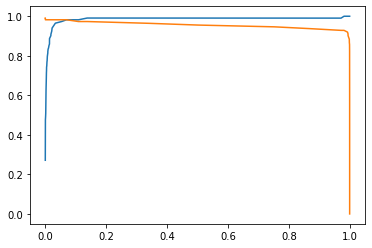

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       724
           1       0.98      0.97      0.98       112

    accuracy                           0.99       836
   macro avg       0.99      0.99      0.99       836
weighted avg       0.99      0.99      0.99       836



,Predicted 0,Predicted 1
Actual 0,722,2
Actual 1,3,109


In [91]:
pr, rc, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.show()
crossover_index = np.max(np.where(pr <= rc))
crossover_cutoff = thresholds[crossover_index]
crossover_recall = rc[crossover_index]

print(classification_report(y_test, y_pred > crossover_cutoff))

m_confusion_test = confusion_matrix(y_test, y_pred > crossover_cutoff)
display(pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1']))



## 2. LSTM with GloVe pre-trained embedding layer

In [ ]:
# To be written?

## Term Frequency Inverse Document Frequency (TF-IDF)
Liao, et.al. suggests that TF-IDF features representation is better than the TF representation. 
 
 Reference:
  Liao, C., Alpha, S., "Dixon.P, "Feature Preparation in Text Categorization", Oracle Corporation, 2004. 

In [49]:
# Explore Term Frequency Inverse Document Frequency (TF-IDF) (Source: )
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [50]:
x_train_vec = vectorizer.transform(x_train).toarray()

In [51]:
model_tdif = svm.SVC(gamma='scale')
model_tdif.fit(x_train_vec, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [52]:
x_test_vec = vectorizer.transform(x_test).toarray()

In [53]:
y_pred_tdif = model_tdif.predict(x_test_vec)

In [54]:
print(classification_report(y_test, y_pred_tdif))

m_confusion_test = confusion_matrix(y_test, y_pred_tdif)
display(pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1']))

print("This model misclassifies {c} genuine SMS as spam and misses only {d} SPAM.".format(c = m_confusion_test[0,1], d = m_confusion_test[1,0]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       724
           1       0.99      0.92      0.95       112

    accuracy                           0.99       836
   macro avg       0.99      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836



,Predicted 0,Predicted 1
Actual 0,723,1
Actual 1,9,103


This model misclassifies 1 genuine SMS as spam and misses only 9 SPAM.


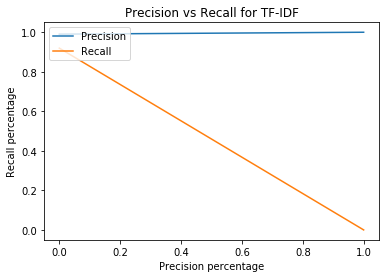

In [65]:
pr, rc, thresholds = precision_recall_curve(y_test, y_pred_tdif)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.xlabel("Precision percentage")
plt.ylabel("Recall percentage")
plt.title("Precision vs Recall for TF-IDF")
plt.legend(['Precision','Recall'], loc='upper left')
plt.show()